# Neutron Transport and Scattering Through a Shielding Layer
v33235cr<br>
University of Manchester  
April 2024

## 1. Random Number Generation:
Although our universe has a lot of inherent randomness to it, especially in quantum systems, the computers we use to simulate and study it are highly deterministic. This means, given the same starting conditions, the computer gives the same output (barring extremely unlikely events like cosmic bit-flips). This is clearly undesirable when studying undeterministic systems.
We will go over some possible work arounds to this issue of generating truly random numbers in this section.

In [1]:
import time
start_time = time.time()
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.constants as pc
import numpy.ma as ma
plt.rcParams.update({'font.size': 16})
plt.style.use('default')

## 1 Pseudo-Random Number Generators (PRNG):
the most common method of generating "random" numbers is by using PRNGs. They are called pseudo because, these algorithms start with a seed value and use mathematical equations to produce a sequence of numbers that "appear" random. However, they are entirely determined by their initial state and the sequence of operations performed, so they are not truly random, they only appear so.

One very common PRNG is the Linear Congruential Generator (LCG) which uses a starting seed and some constants to generate subsequent numbers. It takes the form:
$$X_{n+1} = (a \dot X_n + c)\mod m$$

where $X_{n}$ is the current seed in the sequence, $X_{n+1}$ is the next value in the sequence and $a,c,m$ are constants that define the generator.
The fatal flaw of LCGs is the fact that, once $X_{n+1}$ is equal to the initial value $X_0$, the loop is complete and the LCG will start repeating numbers. The number of iterations before the LCG starts repeating is determined on the initial conditions, which makes it even less reliable. This gives rise to spectral issues, where points generated by an LCG all lie on planes spaced by $a$, as we will soon see. 

But before, let's take a look at numpy's inbuilt function which generates "uniform, random" data using a sophisticated PRNG.

## 1.1 Numpy

In [2]:
def set_axes_title_labels(ax, title, xlabel='X', ylabel='Y', zlabel='Z'):
    """
    Set labels for the given Axes object.

    Parameters:
        ax (matplotlib.axes.Axes): The Axes object to set labels for.
        ax_title (str, optional): The title for the Axes object.
        xlabel (str, optional): The label for the x-axis.
        ylabel (str, optional): The label for the y-axis.
        zlabel (str, optional): The label for the z-axis (for 3D plots).

    Returns:
        None
    """
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if zlabel:
        ax.set_zlabel(zlabel)

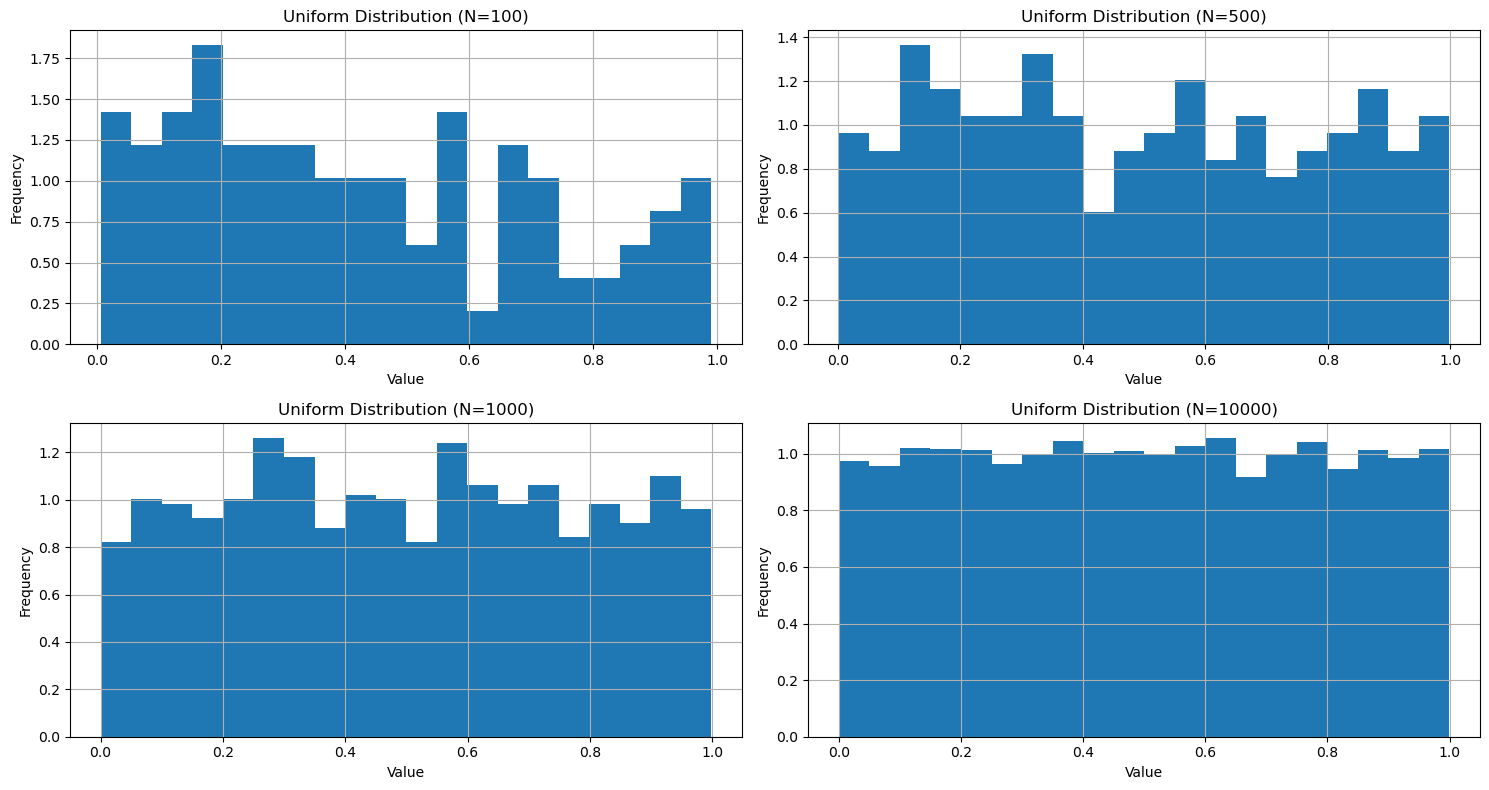

In [3]:
number_points_list = [100, 500, 1000, 10000]  # Number of elements
data_set = [np.random.uniform(0, 1, size=number_points) for number_points in number_points_list]

fig, axs = plt.subplots(2, 2, figsize=(15, 8))  # 2x2 grid of subplots

for i, data in enumerate(data_set):
    row = i // 2  # Determine row index
    col = i % 2   # Determine column index
    ax = axs[row, col]  # Select the appropriate subplot

    # Plot a histogram
    title = f'Uniform Distribution (N={number_points_list[i]})'
    ax.hist(data, bins=20, density=True)
    set_axes_title_labels(ax, title,'Value', 'Frequency', None)
    ax.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


The error on each bin in the histogram is $ \sim \sqrt{N}$ where $N$ is the frequency of that bin. The histogram plots have been normalised such that the area under them = 1. This highlights the tendency of the distribution to even out as $N \rightarrow \infty$, as suggested by the law of large numbers. This law states that the calculated mean of the data approaches the true mean as $N$ increases. The errors on the bins have also clearly decreased. 

Thus we can see that, at least for the magnitude of $N$ that we have looked at, numpy.random.uniform is a fairly reliable way of producing "random" data. Let's now see how 3D points generated by the function look, and check for any noticable spectral lines.

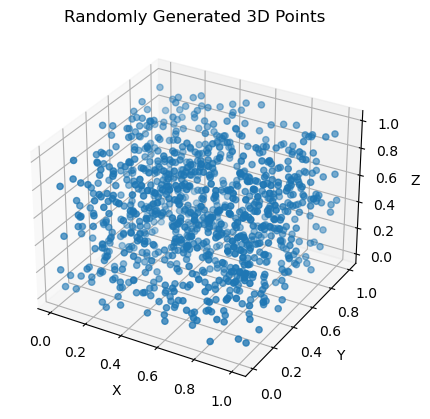

In [4]:
num_points = 1000
points = np.random.uniform(size = (1000,3))

# Display the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(points[:,0], points[:,1], points[:,2])
set_axes_title_labels(ax,'Randomly Generated 3D Points')
plt.show()


## 1.2 Randssp
We dont' see any noticable spectral lines on this scale. Now, we will take a look at a more older PRNG, one that used a much simpler LCG algorithm, the randssp() function.

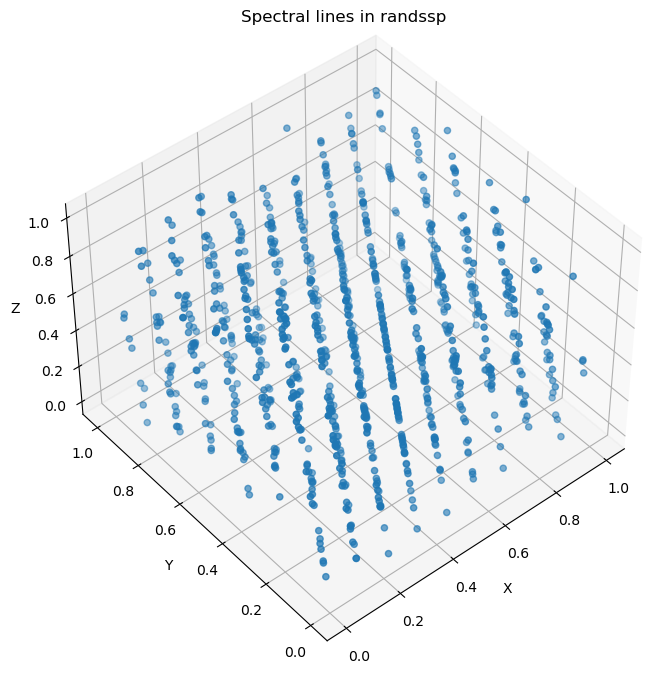

In [5]:
def randssp(p,q):
    
    global m, a, c, x
        
    try: x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    
    return r
pos_data = randssp(3,1000)

fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pos_data[0],pos_data[1],pos_data[2])

set_axes_title_labels(ax,'Spectral lines in randssp')
ax.view_init(elev=45, azim=-130)
plt.show()


As explained earlier, we notice that the data points only lie on certain planes, and are thus not truly random, or even "random" enough.

So far, we have looked at methods of generating random numbers on a linear scale. We will now take a look at how rearranging a probability distribution allows us to get The Inverse Cumulative Distribution Function (ICDF), which lets us use linearly generated random numers to produce exponentially distributed random points.

## 1.3 The Exponential Random Number Generator:
For an exponential function $ y = e^{-\frac{x}{\lambda}} $, the ICDF is given by $ y = -  \lambda log(x) $. We shall now try to use an example value for $ \lambda = 45 $ cm and see how accurately we are able to fit randomly generated data points on a logarithmic fitting routine for $-\lambda$. 

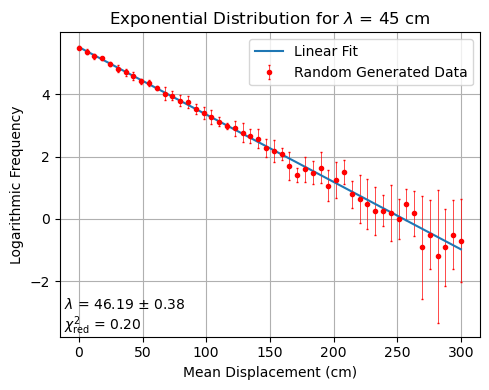

In [6]:
def filter_zero_std(x_data, mean_y_data, std_y_data):
    """
    Filter out data points with zero standard deviation and calculate the error for when taking logarithm on y_data.

    Parameters:
        x_data (array-like): The x-values of the data.
        mean_y_data (array-like): The mean y-values of the data.
        std_y_data (array-like): The standard deviation of y-values.

    Returns:
        tuple: A tuple containing filtered x_data, mean_y_data, and error_y_data.
            x_data_filtered (numpy.ndarray): The x-values with zero standard deviation removed.
            mean_y_data_filtered (numpy.ndarray): The mean y-values corresponding to x_data_filtered.
            error_y_data (numpy.ndarray): The error calculated as std_y_data/mean_y_data for non-zero standard deviation.
    """
    zero_std_indices = std_y_data == 0
    error_y_data = std_y_data[~zero_std_indices] / mean_y_data[~zero_std_indices]
    return x_data[~zero_std_indices], mean_y_data[~zero_std_indices], error_y_data


def exponential_random_generation(matrix_shape, decay_constant):
    """
    Generate an array of random numbers following an exponential distribution.

    Parameters:
        matrix_shape (tuple): The shape of the array to be generated.
        decay_constant (float): The decay constant (lambda) of the exponential distribution.

    Returns:
        numpy.ndarray: An array of random numbers following an exponential distribution.
    """
    # Generate array of uniform random numbers between 0 and 1.
    random_array = np.random.uniform(size=matrix_shape)
    # Use the ICDF to calculate value from probability.
    random_exponential_data = -decay_constant * np.log(random_array)

    return random_exponential_data


def reduced_chi_squared(data, fit, uncertainties):
    """
    Calculate the reduced chi-squared statistic for a linear fit, ie 2 degrees of freedom.

    Parameters:
        data: Array of observed values.
        fit: Array of expected values (model predictions).
        uncertainties: Array of uncertainties on the observed values.

    Returns:
        float: The reduced chi-squared statistic.
    """
    # Calculate the chi-squared statistic
    chi_squared = np.sum(((data - fit) / uncertainties) ** 2)
    
    # Degrees of freedom
    dof = len(data) - 2  # 2 degrees of freedom
    
    # Calculate the reduced chi-squared
    reduced_chi_squared = chi_squared / dof
    
    return reduced_chi_squared


def logarithmic_linear_fitting_plotting(x_data, y_data, y_error, x_label, y_label, title, legend):
    """
    Perform linear fitting with logarithmic transformation and plot the data with error bars.

    Parameters:
        x_data (array): The x-values of the data.
        y_data (array): The y-values of the data.
        y_error (array): The errors associated with the y-values.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        title (str): Title of the plot.
        legend (str): Text for the legend.

    Returns:
        matplotlib.axes.Axes: The Axes object containing the plot.
    """
    # Perform linear fit with logarithmic transformation
    coefficient, covariance = np.polyfit(x_data, np.log(y_data), 1, cov=True, w=1/y_error)
    red_chi_squared = reduced_chi_squared(np.log(y_data), np.polyval(coefficient, x_data), y_error)
    
    data_lambda = -1/coefficient[0]
    data_lambda_error = covariance[0][0]**(0.5)/(coefficient[0]**2)
    
    # Plot data with error bars
    ax.errorbar(x_data, np.log(y_data), yerr=y_error, label='Random Generated Data', fmt='r.', capsize=1, elinewidth=0.5)
    
    # Plot linear fit
    chi_squared_text = r'$\chi^2_{\mathrm{red}}$'
    lambda_text = r'$\lambda$'
    ax.plot(x_data, np.polyval(coefficient, x_data), label='Linear Fit')

    ax.text(0.01, 0, fr'{chi_squared_text} = {red_chi_squared:.2f}', ha='left', va='bottom', transform=ax.transAxes)
    ax.text(0.01, 0.08, fr'{lambda_text} = {data_lambda:.2f} $\pm$ {data_lambda_error:.2f}', 
                                                                        ha='left', va='bottom', transform=ax.transAxes)

    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True)
    
    # Add legend
    ax.legend()
    
    return ax


    
# Parameters of histogram and data
num_samples = 2000
num_iteration = 10
num_bins = 50
histogram_range = (0,300)
mean_bin_values = np.linspace(0,300,num_bins)
bin_frequency_data = np.empty((num_iteration,num_bins))

# Example mean free path
mean_free_path = 45  

# Generate exponential samples, bin the frequencies and collect them over 10 iterations
for histogram_iteration in range(num_iteration):
    data = exponential_random_generation(num_samples, mean_free_path)
    frequency, bin_edges = np.histogram(data, bins= num_bins, range = histogram_range)
    bin_frequency_data[histogram_iteration] = frequency

# Find mean frequency of each bin for 10 iterations, and find the associated standard deviation.
frequency_mean_data = np.mean(bin_frequency_data, axis = 0)
frequency_std_data = np.std(bin_frequency_data, axis = 0)

# Filter all data with 0 standard deviations, which includes bins with only 0/1 frequency data automatically.
filtered_bin_values, filtered_mean_data, filtered_error_data = filter_zero_std(mean_bin_values, 
                                                                             frequency_mean_data, frequency_std_data)

# Fit the filtered data logarithmically, plot it and report the mean free path, associated error and reduced chi square of fit.
plot_title = fr"Exponential Distribution for $\lambda$ = {mean_free_path} cm"
fig, ax = plt.subplots(1,1, figsize = (5,4))
ax = logarithmic_linear_fitting_plotting(filtered_bin_values, filtered_mean_data, filtered_error_data,
                                          "Mean Displacement (cm)", "Logarithmic Frequency", plot_title, "Fitted Line")
fig.tight_layout()
plt.show()


Our calculated $\lambda$ is close to, but not equal to the $\lambda$ that was used to generate the data. We notice that there is significant statistical fluctuations at large displacements. These arise from the frequency values being integer increments rather than smooth, causing large fractional changes in the mean frequency. In extreme cases, the errors appear to be larger than the mean value itself. This uncertaintly can be reduced by taking more data points, as we have already established. 

## 1.4 The Isotropic Radial Vector Generator
Similar to the exponential distribution, the inverse of the trigonometric functions allows us to generate evenly distributed randomized angular parameters, which we can then use to construct the componenets of the radial vector in cartesian coordinates. We note that the sphere is evenly distributed with vectors thanks to the inverse functions. Repeating the same procedure by directly randomizing the angular parameters results in higher concentration of points at the poles.

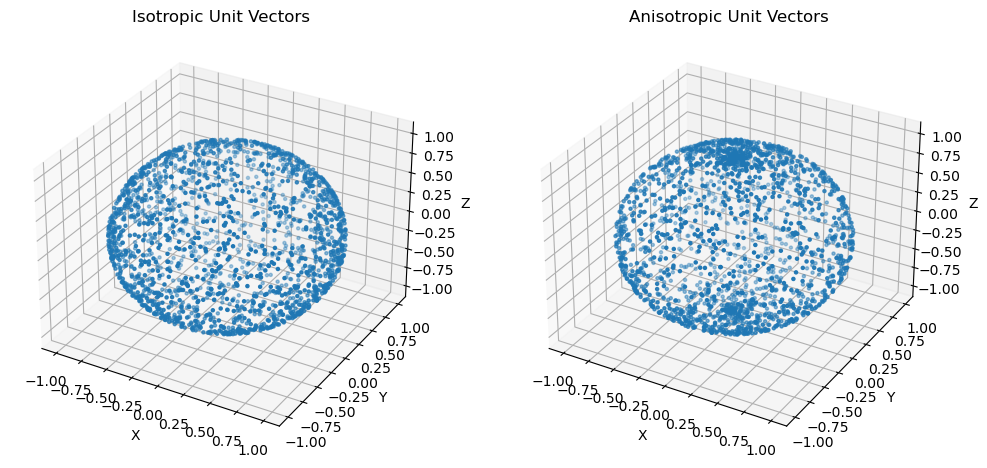

In [7]:
def isotropic_radial_vector(array_shape, radius):
    """
    Generate an array of isotropically distributed random vectors in three dimensions.

    Parameters:
        array_shape (tuple): The shape of the array to be generated.
        radius (float): The radius of the sphere in which the vectors will be distributed.

    Returns:
        numpy.ndarray: An array of random vectors with shape (array_shape, 3).
    """
    # Generate random angles
    theta = np.arccos(2 * np.random.uniform(size=array_shape) - 1)  # theta ranges from 0 to pi
    phi = 2 * np.pi * np.random.uniform(size=array_shape)  # phi ranges from 0 to 2*pi
    
    # Convert spherical coordinates to Cartesian coordinates
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    
    return np.column_stack((x, y, z))

def anisotropic_radial_vector(array_shape, radius):
    """
    Generate an array of anisotropically distributed random vectors in three dimensions.

    Parameters:
        array_shape (tuple): The shape of the array to be generated.
        radius (float): The radius of the sphere in which the vectors will be distributed.

    Returns:
        numpy.ndarray: An array of random vectors with shape (array_shape, 3).
    """
    # Generate random angles
    theta = np.random.uniform(0, np.pi, size= array_shape)  # theta ranges from 0 to pi
    phi = 2 * np.pi * np.random.uniform(size=array_shape)  # phi ranges from 0 to 2*pi
    
    # Convert spherical coordinates to Cartesian coordinates
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    
    return np.column_stack((x, y, z))

# Generate 2000 isotropic unit vectors
num_points = 2000
isotropic_vectors = isotropic_radial_vector(num_points, 1) # generate unit radial vectors
anisotropic_vectors = anisotropic_radial_vector(num_points,1)
# Plot the vectors on a 3D scatter plot to test isotropicity.
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

# Plot on the first subplot
axs[0].scatter(isotropic_vectors[:, 0], isotropic_vectors[:, 1], isotropic_vectors[:, 2], marker='.')
set_axes_title_labels(axs[0],'Isotropic Unit Vectors')

# Plot on the second subplot
axs[1].scatter(anisotropic_vectors[:, 0], anisotropic_vectors[:, 1], anisotropic_vectors[:, 2], marker='.')
set_axes_title_labels(axs[1],'Anisotropic Unit Vectors')

plt.show()


Note the higher concentration of radial vectors at the poles in the anisotropic method, which is undesirable for our  isotropic radial vector generation requirements.

## 1.5 The Exponentially Distributed Radius, Random Direction Vector Generator
We have thus seen that we can generate both exponentially distributed lengths for a given $\lambda$, and also isotropic radial vectors. We can now try and see what happens when we combine the two functions together.

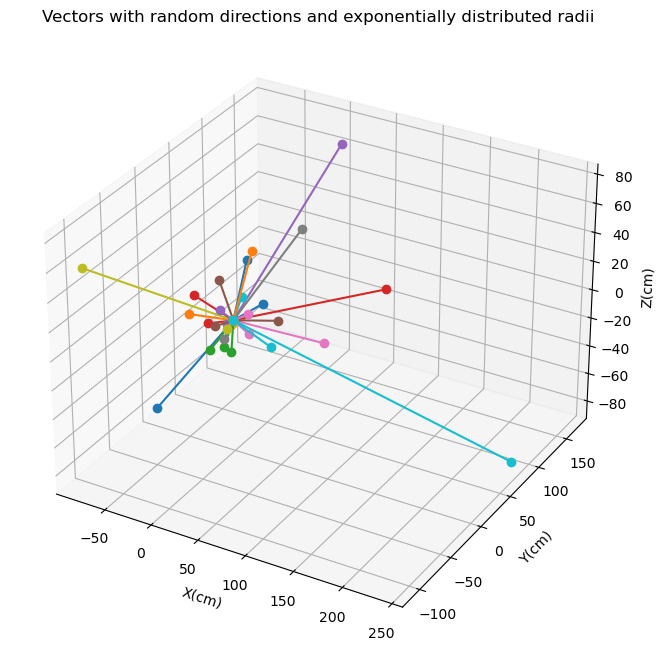

In [8]:
num_points = 30 # plot 30 lines
radial = isotropic_radial_vector(num_points,exponential_random_generation(num_points,mean_free_path))
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

# Plot each line segment
for point in radial:
    # Extract coordinates
    x, y, z = point
    
    # Plot line segment from (0, 0, 0) to (x, y, z)
    ax.plot([0, x], [0, y], [0, z], marker='o')

# Set labels and title
set_axes_title_labels(ax,'Vectors with random directions and exponentially distributed radii',"X(cm)", "Y(cm)","Z(cm)")

# Show plot
plt.show()

As expected, we get an isotropic direction vector and an exponentially distributed radius by combining our two functions.

## 2.Experimental System
The aim of this project is to simulate the transport and scattering of thermal neutron through slabs of water, lead and graphite. When a beam of neutrons travels through the slab, it experiences an attenuation in it's total number of neutrons. We model our system such that this attenuation is caused by neutrons interacting with nuclei of the slab. These interactions cause phenomenon such as scattering and absorption. In extreme cases, such as in radioactive material, the absorption can be further classified into neutron capture and nuclear fission.
For a given phenomenon, say absorption, we can calculate the probability of it occuring using specific quantities of the material in the slab. The scattering cross-section $\sigma_{S} (fm^2)$  as the area which obstructs part of the path of a neutron. It essentially quantifies the likelihood of the neutron interacting with the nucleus. Processes like scattering and absorption are mutually exclusive, a neutron cannot be absorbed and scattered by a nucleus simultaneously. They can thus be added to find the likelihood of either of them. For a material of density $\rho$ and molar mass $M$, we find the number of molecules per cubic length to be 

$$ n = \frac{\rho N_A}{M}$$

thus the total cross-section, is given by 

$$ \sigma_{Total} = n \sigma_{S} + n \sigma_{A} $$

The probability of a particular phenomenon, eg absorption, happening when a neutron interacts with a nucleus can be found using

$$  P_{absorption} = \frac{n \sigma_{A}}{\sigma_{Total}}  $$

We can now see the power of Monte-Carlo simulation of our system. We can computationally predict the phenomenon by using randomly distributed data points, rather than having to rely on statistical approximations.

The mean free path, $\lambda$ is defined as the average distance travelled by a neutron before it interacts with the particles in the slab as outlined earlier. Mathematically, it is

$$ \lambda = \frac{1}{\sigma_{Total}}$$

This implies that the larger the cross sections are, the shorter the distance a neutron would travel before it encounters one.

The size of the cross-sections are affected by a few factors. The energy of the neutrons is one of the most important factors. The greater the neutron's kinetic energy, the smaller the cross-sections become. This is because the additional energy makes the neutron more likely to be able overcome the binding energy of the nucleus.

In this project, we will primarily be looking at thermal neutrons. Thermal neutrons are free neutrons with kinetic energy of approximately $0.025$ eV. Let's first find the $\sigma$ and $\lambda$ for Water, Lead and Graphite to use in our Monte-Carlo simulations.

In [9]:
material_dataset =  [#Material, Absorption, Scattering, Density, Molar Mass
                    ["Water", 0.6652, 103.0, 1.00, 18.0153], 
                    ["Lead", 0.158, 11.221, 11.35, 207.2], 
                    ["Graphite", 0.0045, 4.74, 1.67, 12.011]
                    ]

In [10]:
def material_parameter_calculation(material_data):
    """
    Calculate material parameters based on provided material data.

    Parameters:
        material_data (list): A list containing material data in the following format:
                              [material_density_gcm3, absorption_cross_section_barns, scattering_cross_section_barns,
                               molecular_weight_gmol, molecule_density_atoms_per_cm3]

    Returns:
        tuple: A tuple containing mean free path (cm) and absorption probability.
    """
    # Calculate the number of molecules per unit volume
    molecule_num = material_data[3] * pc.N_A / (material_data[4])

    # Calculate absorption and scattering cross sections per molecule
    absorption_cross_section = molecule_num * (material_data[1] * 10 ** -24)  # Convert barns to cm^2
    scattering_cross_section = molecule_num * (material_data[2] * 10 ** -24)  # Convert barns to cm^2

    # Calculate absorption probability
    absorption_probability = absorption_cross_section / (absorption_cross_section + scattering_cross_section)

    # Calculate mean free path
    mean_free_path = 1 / (absorption_cross_section + scattering_cross_section)

    return mean_free_path, absorption_probability


parameter_dataset = np.array([material_parameter_calculation(material_data) for material_data in material_dataset])
material_list = ["Water", "Lead", "Graphite"]

## 2.1 Random Neutron 3D Walk
Now that we have our neccessarry parameters for our 3 slab materials, we can try and simulate the path(s) that neutron(s) would take through the slabs. To simplify our simulation, we will model the system such that the beam of neutron travels through vacuum and is normally incident on the slab. The distance the neutrons travel before they interact with a neutron can be found using our exponential decay function. 

When a neutron interacts with a nucleus, it can either scatter off of it, or get absorbed by it. The probabilities of these phenomenon occuring is given from their cross-sections. If a neutron scatters off of a nucleus, it travels in a completely random direction for an exponentially distributed distance before it once again interacts with a nucleus. If the neutron travels past the bounds of the slab back into vacuum, it can be considered to have transmitted/reflected, depending on the side of the slab it emerged frim.

We will now simulate this process for 3 neutrons, track their change in position and plot their travel path.

In [11]:
def path_initial_position_generation(num_neutrons, mean_free_length, material_start):
    """
    Generate initial positions and directions for neutrons in a material. Generate positions for the second step along 
    the x-axis, for normally incident thermal neutrons.

    Parameters:
        num_neutrons (int): Number of neutrons to generate positions for.
        mean_free_length (float): Mean free path length of neutrons in the material.
        material_start (float): Starting position of the material along the x-axis.

    Returns:
        numpy.ndarray: Array of shape (num_neutrons, 2, 3) representing initial and second positions 
        and directions of neutrons. There are (num_neutrons) stacks, 2 rows for two position_steps and the 3 columns 
        in each stack corresponds to the evolution of each coordinate of each neutron.
    """
    position_data = np.zeros((num_neutrons, 3))  # Initialize array for positions
    x_path = exponential_random_generation((num_neutrons), mean_free_length) + material_start  # Generate x positions
    total_direction = np.vstack((x_path, np.zeros((2, num_neutrons)))).T  # Generate directions
    return np.dstack((position_data, total_direction))

def path_check_transmission_reflection_absorption(position_data,absorption_probability,material_start,material_end):
    """
    Check which neutrons are transmitted, reflected, or absorbed based on their positions and absorption probability.

    Parameters:
        position_data (numpy.ndarray): Array containing position data of neutrons.
        absorption_probability (float): Probability of neutron absorption.
        material_start (float): Starting position of the material.
        material_end (float): Ending position of the material.

    Returns:
        tuple: A tuple containing transmitted, reflected, absorbed, and leftover neutron paths.
    """
    # Filter out paths of neutron that have fully reflected or transmitted.
    transmitted_mask = (position_data[:,0,-1] > material_end)
    reflected_mask = (position_data[:,0,-1] < material_start)
    leftover_neutron_mask = ~(transmitted_mask | reflected_mask)
    leftover_neutron_paths = position_data[leftover_neutron_mask]
    
    # Find which of the remaining neutrons have been absorbed using Monte-Carlo.
    probabilities = np.random.uniform(0, 1, size = len(leftover_neutron_paths))
    absorption_mask = (probabilities < absorption_probability)
    
    return (position_data[transmitted_mask], position_data[reflected_mask], 
                leftover_neutron_paths[absorption_mask], leftover_neutron_paths[~absorption_mask])


def path_random_single_step(position_data, mean_free_path):
    """
    Simulate multiple random single 3D step of neutrons based on mean free path, using the previous isotropic radial vector 
    function and radius from the exponentially randomised generation. Add this to the current position of each existing 
    neutron and append it to its path history.

    Parameters:
        position_data (numpy.ndarray): Array containing position data of neutrons.
            Each row represents a neutron's position in three dimensions.
        mean_free_path (float): Mean free path of neutrons, representing the average distance
            traveled by a neutron before interacting.

    Returns:
        numpy.ndarray: Array containing the new positions of neutrons after a single 3D step.
    """
    
    num_neutrons = len(position_data)
    random_radius = exponential_random_generation(num_neutrons, mean_free_path)
    position_data = np.dstack((position_data,position_data[:,:,-1]+isotropic_radial_vector((num_neutrons), random_radius)))
    return position_data
    
    
def neutron_phenomenon(x_positions, material_start, material_end):
    """
    Determine the phenomenon undergone by neutrons based on their final positions. Useful for plotting 3-D walk plots.

    Parameters:
        x_positions (numpy.ndarray): Array containing the final x-positions of neutrons.
            Each element represents the final x-position of a neutron.
        material_start (float): Starting position of the material.
        material_end (float): Ending position of the material.

    Returns:
        str: The phenomenon undergone by the neutrons.
    """
    last_position = x[-1]
    if last_position < material_start:
        return "Reflected"
    elif last_position > material_end:
        return "Transmitted"
    else:
        return "Absorbed"

    
def plot_planes(ax, material_start, material_end, length):
    """
    Plot planes representing the boundaries of a material in a 3D plot.

    Parameters:
        ax (matplotlib.axes.Axes): The Axes object to plot on.
        material_start (float): Starting position of the material.
        material_end (float): Ending position of the material.
    """
    # Create a grid for the y and z coordinates
    y = np.linspace(-length, length, 10)
    z = np.linspace(-length, length, 10)
    Y, Z = np.meshgrid(y, z)

    # Plane at x = material_start
    X_start = np.full_like(Y,material_start)
    ax.plot_surface(X_start, Y, Z, alpha=0.8, color='red')

    # Plane at x = material_end
    X_end = np.full_like(Y, material_end)
    ax.plot_surface(X_end, Y, Z, alpha=0.8, color='green')
    
    
def path_infinite_random_walk(position_data, mean_free_length, absorption_probability, material_start, 
                         material_end):
    """
    Simulate an infinite random walk of n number of neutrons within a material.

    This function simulates the movement of neutrons within a material, considering absorption, transmission,
    and reflection probabilities, until all neutrons have been absorbed or escaped the material.

    Parameters:
        position_data (numpy.ndarray): Array containing initial position data of neutrons.
            Each row represents a neutron's initial position in three dimensions after entering the medium.
        mean_free_length (float): Mean free path of neutrons, representing the average distance
            traveled by a neutron before interacting with material.
        absorption_probability (float): Probability of neutron absorption within the material.
        material_start (float): Starting position of the material.
        material_end (float): Ending position of the material.

    Returns:
        list: A list containing the history of neutron paths, including absorbed, reflected, and transmitted neutrons.
            Each element in the list is a numpy.ndarray representing the position data of neutrons at a particular step.
    """
    path_history = []
    while position_data.any():

        (transmitted_neutron_paths, reflected_neutron_paths, 
         absorbed_neutron_paths, leftover_neutron_paths) = path_check_transmission_reflection_absorption(position_data,
                                                                    absorption_probability, material_start, material_end)


        position_data = path_random_single_step(leftover_neutron_paths, mean_free_length)

        path_history.extend(absorbed_neutron_paths)
        path_history.extend(reflected_neutron_paths)
        path_history.extend(transmitted_neutron_paths)

    return path_history

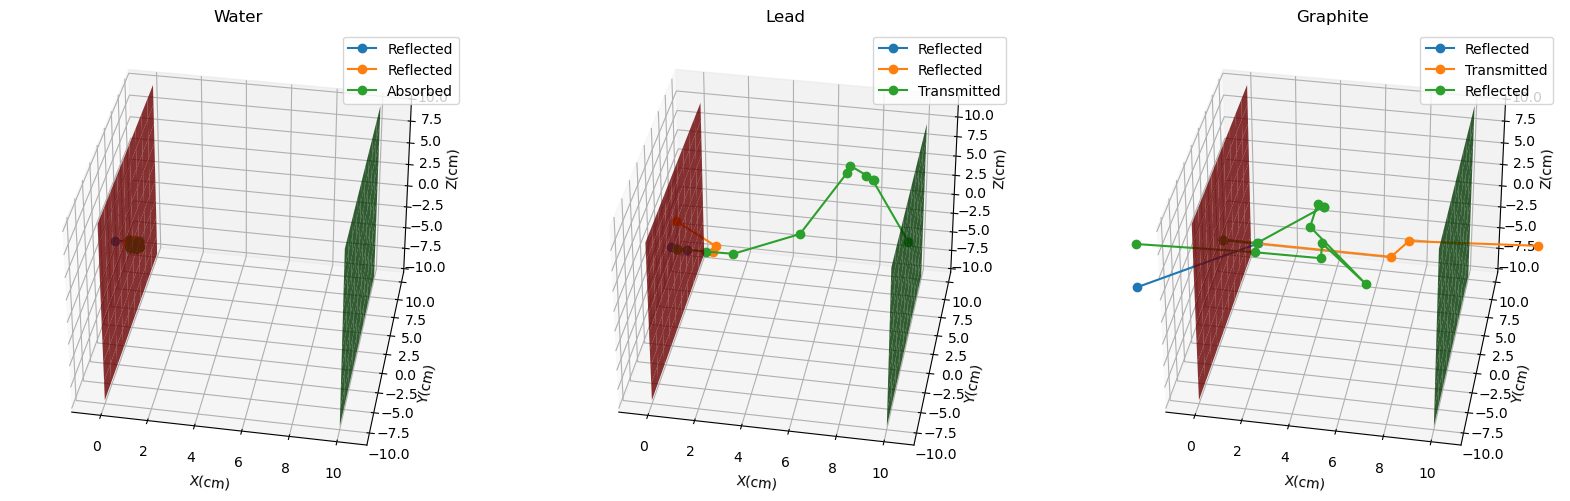

In [25]:
# Slab of material from 0 - 10 cm.
slab_start = 0 # cm
slab_end = 10 # cm

# Use 3 neutrons for visualizing their random walk.
neutron_count = 3


fig, axs = plt.subplots(1, 3, figsize=(20, 20), subplot_kw={'projection': '3d'})
for i,parameter_data in enumerate(parameter_dataset):
    mean_free_path,absorption_probability = parameter_data
    
    # Generate path history data for particular mean free path and absorption probability.
    position_data = path_initial_position_generation(neutron_count,mean_free_path, slab_start)
    total_path_history = path_infinite_random_walk(position_data,mean_free_path,absorption_probability,slab_start, slab_end)

    ax = axs[i]  # Select the appropriate subplot
    #Plot planes for slab boundaries
    plot_planes(ax, slab_start, slab_end, length = 10)
    # Plot each neutron path history
    for path_history in total_path_history:
        # Extract x,y,z coordinates and plot them.
        x,y,z = path_history
        
        # Determine the final outcome of the neutron given its path.
        process = neutron_phenomenon(x, slab_start, slab_end)
        ax.plot(x,y,z, marker='o',label = process)
        
    # Plot parameters.
    set_axes_title_labels(ax,material_list[i],"X(cm)","Y(cm)","Z(cm)")
    ax.set_xlim(slab_start - 1, slab_end + 1)
    ax.view_init(elev=35, azim=280)
    ax.legend()

# Show plot.
plt.show()



We can note a few things from our plots and cross section parameters. Water's lower mean free path is evident in the shorter individual movements of neutrons , as well as being less likely to make it through the whole slab and transmit to the other side. Lead and graphite have relatively similiar travel distances, however lead is more likely to have absorbed neutrons.

## 2.2 Quantifying Processes
Now that we have a visual idea of the neutron-material interactions, we shall now try to find how the likelihood of reflection, absorption and transmission changes with length of the slab of material. The ability to measure the count rates of these processes have significant real life impacts. Underestimating thickness of concrete needed to mitigate radiation from the reactor core of a nuclear power plant can lead to a nuclear hazard, for example.

For a particular material we will attempt to pass 10000 neutrons through a slab at a time. We can repeat this process 10 times for a particular length, which will help us find the errors on the rates.

In [13]:
def count_initial_position_generation(num_neutrons, mean_free_path, material_start):
    """
    Generate initial positions for neutrons. Update it with second step from exponentially distributed random generation. 
    Modified from the previous function to not save path history, but over write the positions instead.

    Parameters:
        num_neutrons (int): The number of neutrons.
        mean_free_path (float): The mean free path of neutrons, representing the average distance
            traveled by a neutron before interacting.
        material_start (float): The starting position of the material.

    Returns:
        numpy.ndarray: An array containing the initial positions of neutrons, generated based on
            an exponential distribution and shifted by the material start.
    """

    return exponential_random_generation(num_neutrons,mean_free_path)+ material_start


def count_transmission_reflection_absorption(position_data, absorption_probability, material_start, material_end):
    """
    Count the number of neutrons reflected, transmitted, and absorbed based on their positions. Remove them from current
    position data set.

    Parameters:
        position_data (numpy.ndarray): Array containing position data of neutrons.
            Each element represents the position of a neutron.
        absorption_probability (float): Probability of neutron absorption within the material.
        material_start (float): Starting position of the material.
        material_end (float): Ending position of the material.

    Returns:
        tuple: A tuple containing the updated position data of neutrons after accounting for
            reflection, transmission, and absorption, as well as the counts of neutrons reflected,
            transmitted, and absorbed.
            - updated_position_data (numpy.ndarray): Updated array containing the positions of left-over neutrons.
            - update_N_R (int): Number of neutrons reflected.
            - update_N_T (int): Number of neutrons transmitted.
            - update_N_A (int): Number of neutrons absorbed.
    """
    reflected_mask = (position_data < material_start)
    update_N_R = len(position_data[reflected_mask])
    position_data = position_data[~reflected_mask]
    
    transmitted_mask = (position_data > material_end)
    update_N_T = len(position_data[transmitted_mask])
    position_data = position_data[~transmitted_mask]
    
    probabilities = np.random.uniform(0, 1, size = len(position_data))
    position_data = position_data[probabilities > absorption_probability]
    update_N_A = len(probabilities[probabilities < absorption_probability])

    return position_data, update_N_R, update_N_T, update_N_A


def count_random_single_step(position_data, mean_free_path):
    """
    Simulate a random single step of neutrons based on mean free path and move the neutrons by this step(s).

    Parameters:
        position_data (numpy.ndarray): Array containing position data of neutrons.
            Each row represents a neutron's position in ONLY X AXIS.
        mean_free_path (float): Mean free path of neutrons, representing the average distance
            traveled by a neutron before interacting.

    Returns:
        numpy.ndarray: Updated array containing the new positions of neutrons after a single step.
            Each row represents a neutron's updated position in ONLY X AXIS.
    """
    
    num_neutrons = len(position_data)
    random_radius_list = exponential_random_generation(num_neutrons, mean_free_path)
    # Only update the x coordinates of the neutrons to improve run-time.
    updated_x = isotropic_radial_vector(num_neutrons, random_radius_list)[:,0]

    updated_position_data = position_data + updated_x
    return updated_position_data
  
    
def count_infinite_random_walk(position_data, mean_free_path, absorption_probability, material_start, material_end):
    """
    Simulate an infinite random walk of neutrons within a material and count reflection, transmission, and absorption.

    This function simulates the movement of neutrons within a material, considering absorption, transmission,
    and reflection probabilities, and counts the number of neutrons reflected, transmitted, and absorbed. It does not 
    track the complete path history of each neutron. It only tracks the most recent x-displacement and acts accordingly.

    Parameters:
        position_data (numpy.ndarray): Array containing position data of neutrons.
            Each row represents a neutron's position in three dimensions.
        mean_free_path (float): Mean free path of neutrons, representing the average distance
            traveled by a neutron before interacting.
        absorption_probability (float): Probability of neutron absorption within the material.
        material_start (float): Starting position of the material.
        material_end (float): Ending position of the material.

    Returns:
        tuple: A tuple containing the counts of neutrons reflected, transmitted, and absorbed.
            - N_R (int): Number of neutrons reflected.
            - N_A (int): Number of neutrons absorbed.
            - N_T (int): Number of neutrons transmitted.
    """

    N_A, N_T, N_R = 0,0,0
    while position_data.any():

        leftover_neutron_paths, update_N_R, update_N_T, update_N_A = count_transmission_reflection_absorption(position_data,
                                                                    absorption_probability,material_start, material_end)        
        
        N_R += update_N_R
        N_A += update_N_A
        N_T += update_N_T
        
        position_data = count_random_single_step(leftover_neutron_paths, mean_free_path)
    return N_R, N_A, N_T 


def rate_data_analysis(neutron_count_data):  
    """
    Quantify the rates of neutron reflection, absorption, and transmission.

    This function takes neutron count data and calculates the mean rates of reflection, absorption,
    and transmission for a particular length, along with their standard deviations.

    Parameters:
        neutron_count_data (numpy.ndarray): Array containing neutron count data.
            Each element represents the count of neutrons reflected, absorbed, and transmitted for 1 iteration at 1 slab length.

    Returns:
        tuple: A tuple containing the mean rates of reflection, absorption, and transmission,
            along with their respective standard deviations.
            - mean_num_reflected (numpy.ndarray): Mean number of neutrons reflected.
            - mean_num_absorbed (numpy.ndarray): Mean number of neutrons absorbed.
            - mean_num_transmitted (numpy.ndarray): Mean number of neutrons transmitted.
            - num_reflected_std (numpy.ndarray): Standard deviation of number of neutrons reflected.
            - num_absorbed_std (numpy.ndarray): Standard deviation of number of neutrons absorbed.
            - num_transmitted_std (numpy.ndarray): Standard deviation of number of neutrons transmitted.
    """
    num_reflected = neutron_count_data[:,:, 0]
    num_absorbed = neutron_count_data[:,:, 1]
    num_transmitted = neutron_count_data[:,:, 2]

    mean_num_reflected = np.mean(num_reflected, axis = 1)
    mean_num_absorbed = np.mean(num_absorbed, axis = 1)
    mean_num_transmitted = np.mean(num_transmitted, axis = 1)

    num_reflected_std = np.std(num_reflected, axis = 1)
    num_absorbed_std = np.std(num_absorbed, axis = 1)
    num_transmitted_std = np.std(num_transmitted, axis = 1)
    
    return mean_num_reflected, mean_num_absorbed, mean_num_transmitted, num_reflected_std, num_absorbed_std, num_transmitted_std


def rate_plot_function(material_name, mean_N_T, mean_N_A, mean_N_R, slab_end_list):
    """
    Plot the rates of neutron reflection, absorption, and transmission against slab length.

    This function plots the mean rates of neutron reflection, absorption, and transmission
    as functions of the slab length.

    Parameters:
        material_name (str): Name of the material being analyzed.
        mean_N_T (numpy.ndarray): Mean number of neutrons transmitted for each slab length.
        mean_N_A (numpy.ndarray): Mean number of neutrons absorbed for each slab length.
        mean_N_R (numpy.ndarray): Mean number of neutrons reflected for each slab length.
        slab_end_list (numpy.ndarray): List corresponding to slab lengths.

    Returns:
        matplotlib.axes.Axes: The Axes object containing the plot.
    """


    ax.plot(slab_end_list,mean_N_A)
    ax.plot(slab_end_list,mean_N_T)
    ax.plot(slab_end_list,mean_N_R)
    
    ax.legend(['Neutrons Absorbed','Neutrons Transmitted','Neutrons Reflected'])
    set_axes_title_labels(ax, material_name, "Slab length(cm)", "Number of neutrons", None)
    ax.grid(True)
    return ax

In [14]:
slab_start = 0 # cm
slab_end = 10 # cm
neutron_count = 10000 # number of neutrons

for i, parameter_data in enumerate(parameter_dataset):
    
    # Find the neutron rates for 10 iterations of slab length 10 cm.
    mean_free_path,absorption_probability = parameter_data
    position_data = [count_initial_position_generation(neutron_count,mean_free_path, slab_start) for iterations in range(10)]
    simulation_rates = np.array([count_infinite_random_walk(position_data[iterations],mean_free_path,absorption_probability,
                                                            slab_start,slab_end) for iterations in range(10)])
    # Process and print the calculated neutron rates.
    mean_N_R, mean_N_A, mean_N_T = np.hsplit(np.mean(simulation_rates,axis = 0),3)
    N_R_std, N_A_std, N_T_std = np.hsplit(np.std(simulation_rates,axis = 0),3)
    
    print(f"Material: {material_list[i]} \n"  
         f"Reflection Rate: {mean_N_R[0]*100/neutron_count:.1f} ± {N_R_std[0]*100/neutron_count:.1f} %\n"
         f"Absorption Rate: {mean_N_A[0]*100/neutron_count:.1f} ± {N_A_std[0]*100/neutron_count:.1f} %\n"
         f"Transmission Rate: {mean_N_T[0]*100/neutron_count:.1f} ± {N_T_std[0]*100/neutron_count:.1f} %\n"
         "----------------------------------")


Material: Water 
Reflection Rate: 79.6 ± 0.5 %
Absorption Rate: 20.1 ± 0.6 %
Transmission Rate: 0.3 ± 0.1 %
----------------------------------
Material: Lead 
Reflection Rate: 61.7 ± 0.5 %
Absorption Rate: 10.0 ± 0.2 %
Transmission Rate: 28.3 ± 0.5 %
----------------------------------
Material: Graphite 
Reflection Rate: 68.3 ± 0.5 %
Absorption Rate: 0.8 ± 0.1 %
Transmission Rate: 31.0 ± 0.4 %
----------------------------------


We can repeat this process for a few different slab thicknesses of the same material, to be able to fit them logarithmically and compute their mean free path.

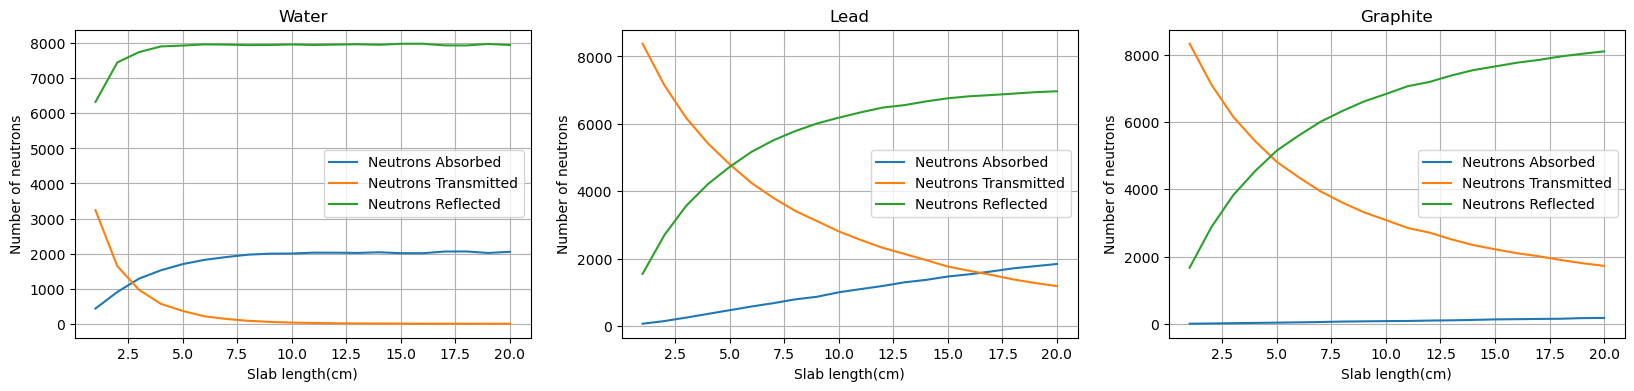

In [15]:
# Create an array of slab lengths 1 - 20 cms.
slab_end_list = np.arange(slab_start+1,slab_start+21,1)

# Initialize an empty array to store all processed neutron transmission rate data for each material
transmission_rate_dataset = []

fig, axs = plt.subplots(1, 3, figsize=(20, 4))

for i,parameter_data in enumerate(parameter_dataset):
    # Parameters of material(s)
    material = material_list[i]
    mean_free_path,absorption_probability = parameter_data
    
    # Find transmission rates for 10 iterations of each slab length and store them.
    position_data = [count_initial_position_generation(neutron_count,mean_free_path,
                                                slab_start) for iterations in range(10)]

    neutron_count_data = np.array([[count_infinite_random_walk(position_data[iterations],mean_free_path,absorption_probability,
                                                                       slab_start,slab_end) for iterations in range(10)] 
                                                                                           for slab_end in slab_end_list])
    # Find mean and standard deviation of the different rates, and plot them.
    (mean_num_reflected, mean_num_absorbed, mean_num_transmitted, 
    num_reflected_std, num_absorbed_std, num_transmitted_std) = rate_data_analysis(neutron_count_data)
    ax = axs[i]
    ax = rate_plot_function(material, mean_num_transmitted, mean_num_absorbed, mean_num_reflected, slab_end_list)

    # Save transmission rate data.
    transmission_rate_dataset.append([filter_zero_std(slab_end_list, mean_num_transmitted, num_transmitted_std)])

plt.show()


We once again notice a few important features. In water, beyond a certain point, there was virtually no neutrons being transmitted. Once again, this can be related to its much smaller mean free path and high scattering cross-section, which pertubates the neutrons' paths significantly. Lead and graphite have very similar transmission counts across all distances, and Lead has a higher absorption count as expected from its higher absorption cross-section than graphite. All three transmission counts show an exponential decay, as expected. 

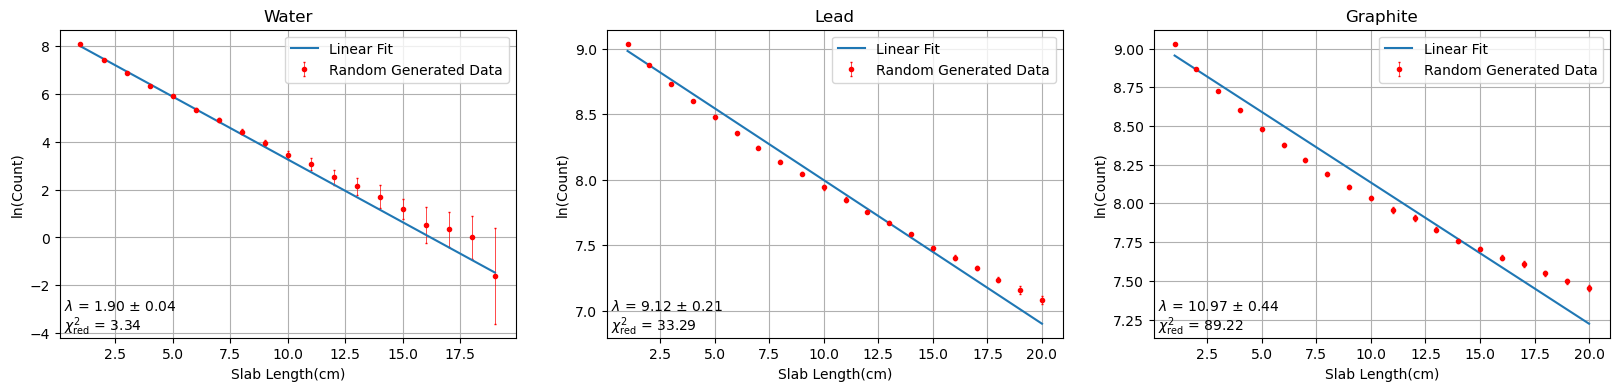

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
# Fit the transmission rate against slab length using a logarithmic fitting routine and plot the data and calculated mean free
# length and uncertainty, along with the reduced chi squared on the fit.
# Repeat for all 3 material.
for i, [(slab_length_list, mean_num_transmitted, filtered_num_transmitted_error)] in enumerate(transmission_rate_dataset):
    ax = axs[i]
    ax = logarithmic_linear_fitting_plotting(slab_length_list, mean_num_transmitted, filtered_num_transmitted_error,
                                             'Slab Length(cm)', 'ln(Count)', material_list[i],[])
plt.show()


In the fit for graphite and lead, we can see it is not perfectly linear, and has very small error bars. The non-linearity is more pronounced in graphite. This is most likely from the way he have modelled the transmission rate to be purely exponential, and that neutrons were attenuated over distance. In reality, some of the neutrons might manage to back-scatter their way into transmission. All loss in count is not due to absorption as expected by theory. This would explain graphite having a relatively higher count-rate than Lead in the higher distances, as graphite has a much smaller absorption cross-section.

## Woodcock Method:
The Woodcock Method is an alternative to numerically intensive dimensional calculations when trying to model neutron transport through two consecutive slabs of materials. We first consider the smaller of two mean free paths as the system's mean free path. We can account for travel in the region with greater mean free path by considering a fraction $\frac{\lambda_{min}}{\lambda_{max}}$ of steps in that region to be ficticious, we ensure that we do not over count the number of interactions. We can verify the procedure by filling one of the slabs to be vacuum, which should return us the same value as we get normally.

In [17]:
def woodcock_parameters_calculation(lambda1, lambda2):
    """
    Calculate Woodcock parameters lambda_t, smaller mean free path and v_param, constant probability to check ficticiousness

    Parameters:
        lambda1 (float): Decay constant for first material.
        lambda2 (float): Decay constant for second material.

    Returns:
        tuple: Tuple containing lambda_t (minimum of lambda1 and lambda2)
        and v_param (ratio of lambda_t to maximum of lambda1 and lambda2) functionally same as doing it using sigma.
    """
    lambda_t = min((lambda1, lambda2))
    v_param = lambda_t/max((lambda1, lambda2))

    return lambda_t, v_param

def woodcock_initial_position_generation(num_neutrons, mean_free_path, material_start):
    """
    Generate initial positions and direction vectors for neutrons.

    Parameters:
        num_neutrons (int): Number of neutrons.
        mean_free_path (float): Mean free path.
        material_start (float): Start position of the material.

    Returns:
        tuple: Tuple containing arrays of initial positions and initial direction vectors.
    """

    empty_array = np.empty(num_neutrons)
    direction_vector = np.full_like(empty_array, 1)
    
    return exponential_random_generation(num_neutrons,mean_free_path)+ material_start, direction_vector
    
def woodcock_transmission_reflection(position_data, direction_data, material_start, material_end):
    """
    Filter neutrons that have exited the system and update counts.

    Parameters:
        position_data (array): Array of neutron positions.
        direction_data (array): Array of neutron direction vectors.
        material_start (float): Start position of the material.
        material_end (float): End position of the material.

    Returns:
        tuple: Tuple containing updated position and direction data, and counts of
        reflected and transmitted neutrons.
    """

    reflected_mask = (position_data < material_start)
    update_N_R = len(position_data[reflected_mask])
    position_data = position_data[~reflected_mask]
    direction_data = direction_data[~reflected_mask]
    
    transmitted_mask = (position_data > material_end)

    update_N_T = len(position_data[transmitted_mask])
    position_data = position_data[~transmitted_mask]
    direction_data = direction_data[~transmitted_mask]

    return position_data, direction_data, update_N_R, update_N_T

def woodcock_ficticious_random_single_step(position_data, current_direction_data, mean_free_path):
    """
    Simulate random single steps for fictitious neutrons.

    Parameters:
        position_data (array): Array of neutron positions.
        current_direction_data (array): Array of current neutron direction vectors.
        mean_free_path (float): Mean free path.

    Returns:
        array: Array of updated position data.
    """
    num_neutrons = len(position_data)
    random_radius_array = exponential_random_generation(num_neutrons, mean_free_path)
    updated_position_data = position_data + current_direction_data*random_radius_array
    return updated_position_data
  
def woodcock_real_random_single_step(position_data, absorption_probability, mean_free_path):
    """
    Simulate random single steps for real neutrons.

    Parameters:
        position_data (array): Array of neutron positions.
        absorption_probability (float): Absorption probability.
        mean_free_path (float): Mean free path.

    Returns:
        tuple: Tuple containing arrays of updated position data and direction vectors,
        and count of absorbed neutrons.
    """
    num_neutrons = len(position_data)
    probabilities = np.random.uniform(0,1, size = num_neutrons)
    update_N_A = len(position_data[probabilities < absorption_probability])
    position_data = position_data[probabilities > absorption_probability]

    num_neutrons = len(position_data)

    random_radius_array = exponential_random_generation(num_neutrons, mean_free_path)
    random_direction_array = isotropic_radial_vector(num_neutrons, 1)
    position_data += random_radius_array*random_direction_array[:,0]
    return (position_data, random_direction_array[:,0]), update_N_A
    
def layer_detection(position_data, direction_data, slab_interface):
    """
    Detect neutrons in different layers of the material.

    Parameters:
        position_data (array): Array of neutron positions.
        direction_data (array): Array of neutron direction vectors.
        slab_interface (float): Interface between material layers.

    Returns:
        tuple: Tuple containing arrays of neutrons in layers above and below the interface.
    """

    layer_mask = (position_data < slab_interface)
    
    return (position_data[layer_mask], direction_data[layer_mask]), (position_data[~layer_mask], direction_data[~layer_mask])

def woodcock_infinite_random_walk(neutron_count, lambda_data, absorption_data,slab_start,slab_interface, slab_end):
    """
    Simulate infinite random walk of neutrons through material layers.

    Parameters:
        neutron_count (int): Number of neutrons.
        lambda_data (tuple): Tuple of decay constants for material layers.
        absorption_data (tuple): Tuple of absorption probabilities for material layers.
        slab_start (float): Start position of the material slab.
        slab_interface (float): Interface between material layers.
        slab_end (float): End position of the material slab.

    Returns:
        tuple: Tuple containing counts of reflected, absorbed, and transmitted neutrons.
    """

    N_R, N_A, N_T = 0,0,0
    (lambda1,lambda2) = lambda_data
    (absorption_probability1, absorption_probability2) = absorption_data

    lambda_t, v_param = woodcock_parameters_calculation(lambda1, lambda2)
    position_data, direction_data = woodcock_initial_position_generation(neutron_count, lambda_t, slab_start)
    if lambda1 >= lambda2:
        while position_data.any():

            position_data, direction_data, update_N_R, update_N_T =  woodcock_transmission_reflection(position_data, 
                                                                          direction_data, slab_start, slab_end)
            layer_1_data, layer_2_data = layer_detection(position_data, direction_data, slab_interface)

            processed_layer_1_data, update_N_A1 = sigma_min_routine(np.array(layer_1_data), v_param, lambda_t, absorption_probability1)
            
            processed_layer_2_data, update_N_A2 = sigma_max_routine(layer_2_data, lambda_t, absorption_probability2)
            position_data, direction_data = np.hstack((processed_layer_1_data, processed_layer_2_data))

            N_R += update_N_R
            N_A += update_N_A1
            N_A += update_N_A2
            N_T += update_N_T
    else:
        while position_data.any():

            position_data, direction_data, update_N_R, update_N_T =  woodcock_transmission_reflection(position_data, 
                                                                          direction_data, slab_start, slab_end)
            layer_1_data, layer_2_data = layer_detection(position_data, direction_data, slab_interface)

            processed_layer_1_data, update_N_A1 = sigma_max_routine(layer_1_data, lambda_t, absorption_probability1)

            processed_layer_2_data, update_N_A2 = sigma_min_routine(np.array(layer_2_data), v_param, lambda_t, absorption_probability2)
            position_data, direction_data = np.hstack((processed_layer_1_data, processed_layer_2_data))

            N_R += update_N_R
            N_A += update_N_A1
            N_A += update_N_A2
            N_T += update_N_T

    return N_R, N_A, N_T

def sigma_min_routine(layer_data, v_param, mean_free_path, absorption_probability):
    """
    Simulate scattering for neutrons in layer with higher mean free path.

    Parameters:
        layer_data (array): Array of neutron positions and direction vectors.
        v_param (float): Ratio of lambda_t to maximum decay constant.
        mean_free_path (float): Mean free path.
        absorption_probability (float): Absorption probability.

    Returns:
        tuple: Tuple containing arrays of processed neutron data and count of absorbed neutrons.
    """

    v = np.random.uniform(0,1, size = len(layer_data[0]))
    ficticious_neutrons = layer_data.T[v > v_param]
    ficticious_neutrons = ficticious_neutrons.T
    ficticious_neutrons[0] = woodcock_ficticious_random_single_step(ficticious_neutrons[0], ficticious_neutrons[1],
                                                                                                            mean_free_path)

    real_neutrons = layer_data.T[v <= v_param]
    real_neutrons = real_neutrons.T

    filtered_real_neutrons, update_N_A = woodcock_real_random_single_step(real_neutrons[0], absorption_probability, 
                                                                                                            mean_free_path)

    return np.hstack((ficticious_neutrons,filtered_real_neutrons)), update_N_A

def sigma_max_routine(layer_data, mean_free_path, absorption_probability):
    """
    Simulate scattering for neutrons in layer with lower mean free path.

    Parameters:
        layer_data (array): Array of neutron positions and direction vectors.
        mean_free_path (float): Mean free path.
        absorption_probability (float): Absorption probability.

    Returns:
        tuple: Tuple containing arrays of processed neutron data and count of absorbed neutrons.
    """
    
    filtered_layer, update_N_A = woodcock_real_random_single_step(layer_data[0], absorption_probability, mean_free_path)
    return filtered_layer, update_N_A

In [18]:
# Infinite attenuation length, no scattering in vacuum
vacuum_lambda, vacuum_absorption = np.inf, 0 
water_lambda, lead_lambda, graphite_lambda = parameter_dataset[:,0]
water_absorption, lead_absorption, graphite_absorption = parameter_dataset[:,1]

slab_start = 0
slab_interface = 10
slab_end = 20
neutron_count = 10000

test_cases = ["Vacuum-Water","Vacuum-Lead", "Graphite-Lead"]
test_cases_lambda = [[vacuum_lambda, water_lambda],[lead_lambda, vacuum_lambda], [graphite_lambda, lead_lambda]]
test_cases_absorption = [[vacuum_absorption,water_absorption],[lead_absorption,vacuum_absorption],[graphite_absorption,lead_absorption]]

for i, case in enumerate(test_cases):
    simulation_rates = [woodcock_infinite_random_walk(neutron_count,test_cases_lambda[i], test_cases_absorption[i],slab_start, 
                                                                  slab_interface, slab_end) for iterations in range(10)]
    mean_N_R, mean_N_A, mean_N_T = np.hsplit(np.mean(simulation_rates,axis = 0),3)
    N_R_std, N_A_std, N_T_std = np.hsplit(np.std(simulation_rates,axis = 0),3)
    print(f"Slab Combination: {case}  {slab_start}-{slab_interface}-{slab_end} cm \n"
     f"Reflection Rate: {mean_N_R[0]*100/neutron_count:.1f} ± {N_R_std[0]*100/neutron_count:.1f} %\n"
     f"Absorption Rate: {mean_N_A[0]*100/neutron_count:.1f} ± {N_A_std[0]*100/neutron_count:.1f} %\n"
     f"Transmission Rate: {mean_N_T[0]*100/neutron_count:.1f} ± {N_T_std[0]*100/neutron_count:.1f} %\n"
     "----------------------------------")


Slab Combination: Vacuum-Water  0-10-20 cm 
Reflection Rate: 79.8 ± 0.3 %
Absorption Rate: 19.9 ± 0.3 %
Transmission Rate: 0.3 ± 0.0 %
----------------------------------
Slab Combination: Vacuum-Lead  0-10-20 cm 
Reflection Rate: 61.9 ± 0.4 %
Absorption Rate: 10.0 ± 0.2 %
Transmission Rate: 28.1 ± 0.4 %
----------------------------------
Slab Combination: Graphite-Lead  0-10-20 cm 
Reflection Rate: 78.8 ± 0.2 %
Absorption Rate: 7.1 ± 0.2 %
Transmission Rate: 14.1 ± 0.3 %
----------------------------------


Our Vacuum-Water and Lead-Vacuum systems both agree with our previous single layer values for water and lead at 10 cm slab length to 1 standard deviation. This shows that the woodcock method approximates very well to our initial method under single slab conditions, and any uncertainty in the approximation is much smaller than the uncertainty from our monte-carlo simulation with limited number of neutrons.  


## Appendix: Nuclear Fission
The Nuclear power industry is arguably one of the most important use cases for the neutron transport simulation. Compared to non radio-active elements which only have absorption and scattering cross-sections, radio-active elements like Uranium-235 have a chance to undergo nuclear fission after absorbing a neutron. We define this as 

$$\sigma_{absorption} = \sigma_{fission} + \sigma_{capture} $$

When a $U^{235}$ nucleus absorbs a neutron, it has a small chance of becoming $U^{236}$. It is more likely to however, undergo nuclear fission and split into several smaller elements. As a by-product of nuclear fission, $U^{235}$ releases 2-3 neutrons, with 2.43 on average [1]. These neutrons can go on to collide with more nuclei. As a result, $U^{235}$ fission chain-reaction is self-sustaining. Monitoring and controlling the fission rate is a major part of ensuring safety in nuclear power plants.

In [19]:
def uranium_path_check_transmission_reflection_absorption(position_data, absorption_probability, fission_probability,
                                                                                      material_start, material_end):
    """
    Check which neutrons are transmitted, reflected, or absorbed based on their positions and absorption probability.

    Parameters:
        position_data (numpy.ndarray): Array containing position data of neutrons.
        absorption_probability (float): Probability of neutron absorption.
        fission_probability (float): Probability of neutron fission.
        material_start (float): Starting position of the material.
        material_end (float): Ending position of the material.

    Returns:
        tuple: A tuple containing transmitted, reflected, absorbed, and leftover neutron paths.
    """
    # Filter out paths of neutron that have fully reflected or transmitted.
    transmitted_mask = (position_data[:,0,-1] > material_end)
    reflected_mask = (position_data[:,0,-1] < material_start)
    leftover_neutron_mask = ~(transmitted_mask | reflected_mask)
    leftover_neutron_paths = position_data[leftover_neutron_mask]
    
    # Find which of the remaining neutrons have been absorbed using Monte-Carlo.
    probabilities = np.random.uniform(0, 1, size = len(leftover_neutron_paths))
    fission_mask = (probabilities < fission_probability *absorption_probability)
    capture_mask =  (probabilities <  absorption_probability * (1- fission_probability)) 
    scattered_mask = (probabilities >  absorption_probability)
    return (position_data[transmitted_mask], position_data[reflected_mask],
            leftover_neutron_paths[fission_mask], leftover_neutron_paths[capture_mask], leftover_neutron_paths[scattered_mask])


def uranium_path_infinite_random_walk(position_data, mean_free_length, absorption_probability,fission_probability, 
                                                                                              material_start,material_end):
    """
    Simulate an infinite random walk of n number of neutrons within Uranium. Tracks new neutrons produced from fission.

    This function simulates the movement of neutrons within Uranium, considering absorption, transmission,
    and reflection probabilities, until all neutrons have been absorbed or escaped the material.

    Parameters:
        position_data (numpy.ndarray): Array containing initial position data of neutrons.
            Each row represents a neutron's initial position in three dimensions after entering the medium.
        mean_free_length (float): Mean free path of neutrons, representing the average distance
            traveled by a neutron before interacting with material.
        absorption_probability (float): Probability of neutron absorption within the material.
        fission_probability (float): Probability of neutron fission within the material.
        material_start (float): Starting position of the material.
        material_end (float): Ending position of the material.

    Returns:
        list: A list containing the history of neutron paths, including absorbed, reflected, and transmitted neutrons.
            Each element in the list is a numpy.ndarray representing the position data of neutrons at a particular step.
    """
    path_history = []
    iteration = 0 
    while position_data.any() and iteration < 15: # Exits the function after 15 loops to prevent crashing in extreme cases.
        iteration += 1
        (transmitted_neutron_paths, reflected_neutron_paths, fissioned_neutron_paths,
         captured_neutron_paths, leftover_neutron_paths) = uranium_path_check_transmission_reflection_absorption(position_data,
                                                                                    absorption_probability, fission_probability,
                                                                                                material_start, material_end)
        

        neutron_products_per_fission = fission_product_function(len(fissioned_neutron_paths))
        product_paths = np.repeat(fissioned_neutron_paths, neutron_products_per_fission, axis=0)

        leftover_neutron_paths = np.append(leftover_neutron_paths, product_paths, axis = 0)

        position_data = path_random_single_step(leftover_neutron_paths, mean_free_length)
        
        path_history.extend(captured_neutron_paths)
        path_history.extend(reflected_neutron_paths)
        path_history.extend(transmitted_neutron_paths)

    return path_history

def fission_product_function(number_fissioned_neutrons):
    """
    Simulate the number of neutron products per fission event, with a mean number of 1.43.

    Parameters:
        number_fissioned_neutrons (int): Number of neutrons that are cauing fission.

    Returns:
        array: Array containing the number of neutron products per fission event.
    """
    neutron_products_per_fission = (np.round(np.random.uniform(0.97,1.97, size = number_fissioned_neutrons))).astype(int)
    return neutron_products_per_fission

In [20]:
                    #Absorption, Scattering, Density, Molar Mass, Fission
    
uranium_dataset = [["Thermal Neutron Transport", 684, 10, 19.05, 235, 585], # Thermal neutron cross-sections.
                   ["Fast Neutron Transport", 1.09, 4, 19.05, 235, 1]] # Fast neutron cross-sections.

fission_probability_data = np.array([585/684, 1/1.09])
uranium_parameters = [material_parameter_calculation(uranium_data) for uranium_data in uranium_dataset]

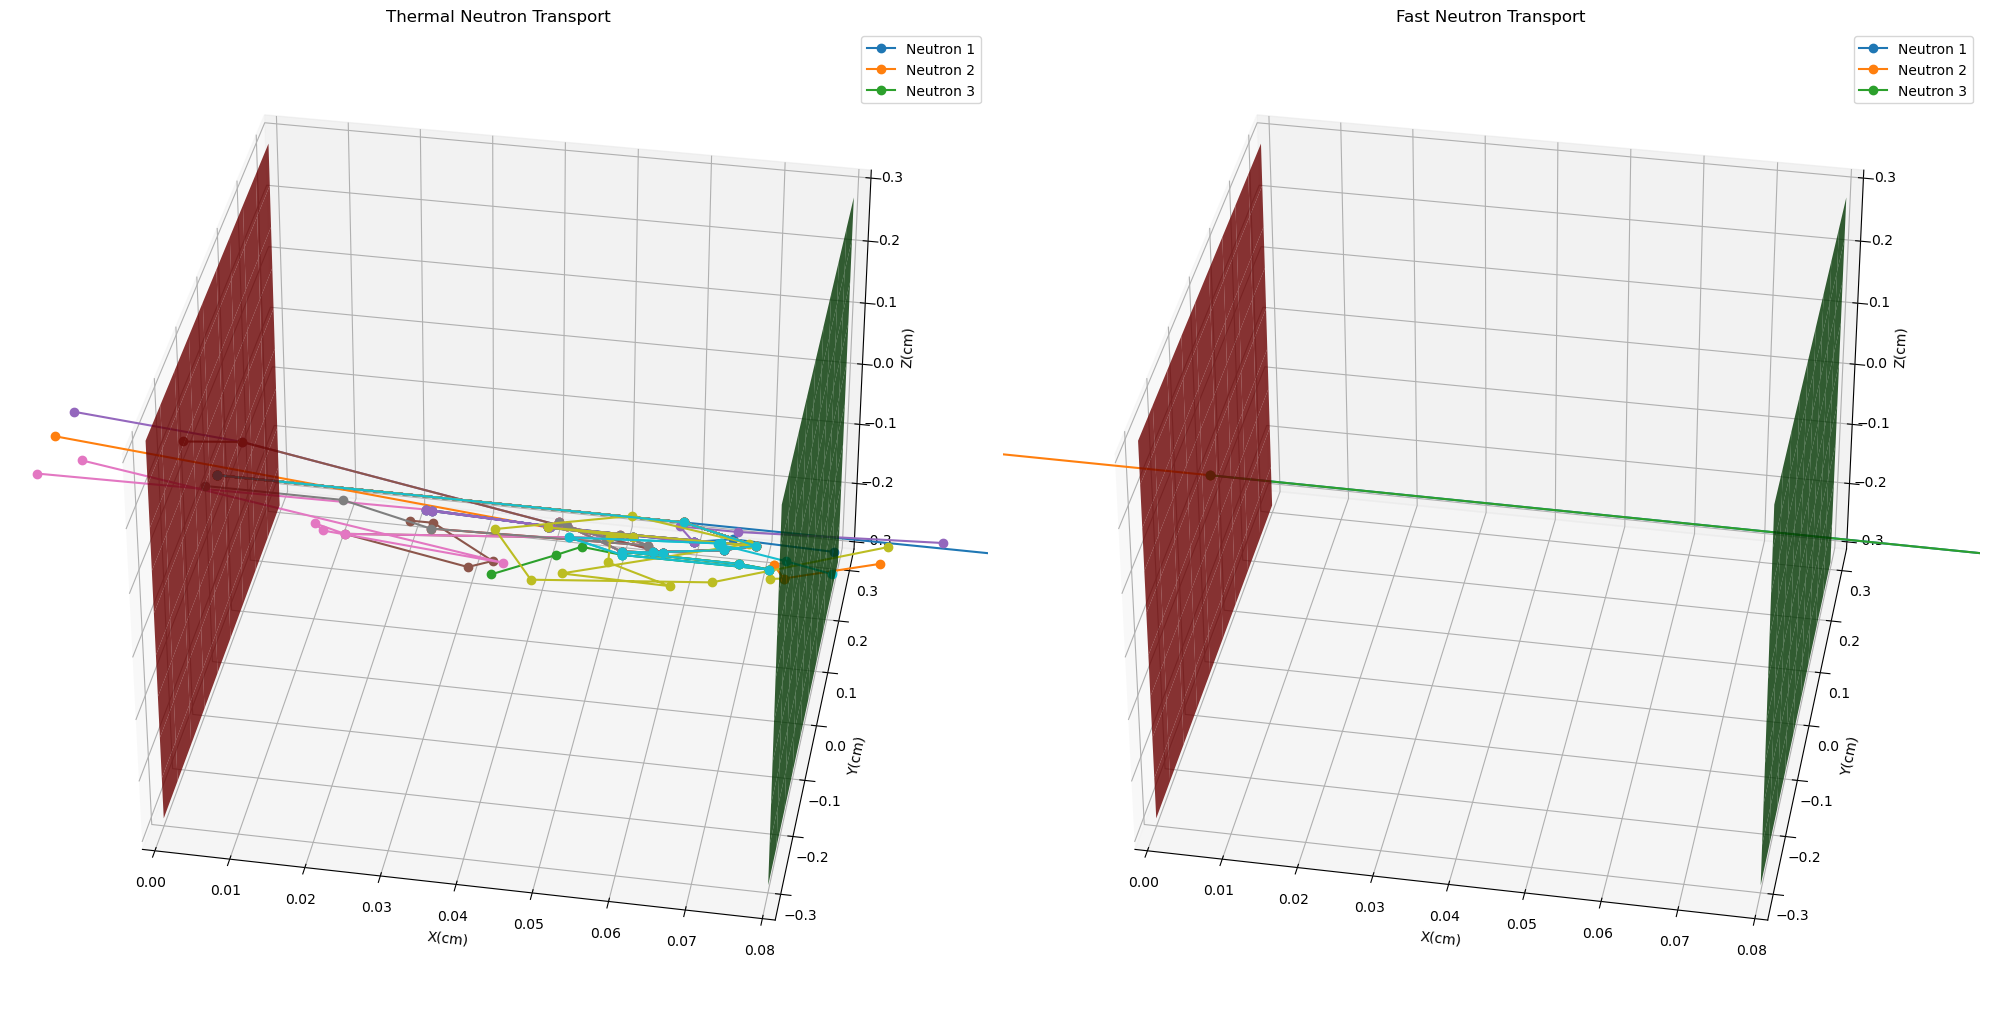

In [23]:
# Slab of material from 0 - 0.8 cm.
slab_start = 0 # cm
slab_end = .08 # cm

# Use 3 neutrons for visualizing their random walk.
neutron_count = 3

fig, axs = plt.subplots(1, 2, figsize=(20, 20), subplot_kw={'projection': '3d'})

for i,parameter_data in enumerate(uranium_parameters):
    mean_free_path,absorption_probability = parameter_data
    fission_probability = fission_probability_data[i]
    title = uranium_dataset[i][0]

    # Generate path history data for particular mean free path and absorption probability.
    position_data = path_initial_position_generation(neutron_count,mean_free_path, slab_start)
    total_path_history = uranium_path_infinite_random_walk(position_data,mean_free_path,absorption_probability,
                                                           fission_probability,slab_start, slab_end)

    ax = axs[i]
    #Plot planes for slab boundaries
    plot_planes(ax, slab_start, slab_end, length = 0.3)
    # Plot each neutron path history
    for path_history in total_path_history:
        # Extract x,y,z coordinates and plot them.
        x,y,z = path_history

        # Determine the final outcome of the neutron given its path.
        process = neutron_phenomenon(x, slab_start, slab_end)
        ax.plot(x,y,z, marker='o',label = process)

    # Plot parameters.
    set_axes_title_labels(ax,title,"X(cm)","Y(cm)","Z(cm)")
    ax.set_xlim(slab_start, slab_end)

    ax.view_init(elev=35, azim=280)
    ax.legend(['Neutron 1', 'Neutron 2', 'Neutron 3'])
plt.tight_layout()  # Adjust layout to prevent overlap
# Show plot.

plt.show()



Due to the high absorption cross section of thermal neutron, we can see a large number of fission processes occur. Over the span of just 0.08 cm our neutron population rate has exponentially increased. In the  Fast Neutron Transport, the neutron is completely unattenuated in most cases for the same distance. The two plots together display the effect of kinetic energy in neutron transport. 

## References
[1] Nuclear Power. (n.d.). Uranium 235 Fission | Equation & Energy | nuclear-power.com. [online] Available at: https://www.nuclear-power.com/nuclear-power-plant/nuclear-fuel/uranium/uranium-235/uranium-235-fission/.

In [22]:
end_time = time.time()
print("Time taken", end_time - start_time)

Time taken 67.77782678604126
